In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from textblob import TextBlob
import textstat
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from ast import literal_eval

from src.scripts.load_save import *
from src.data.dataprocessing import *
from src.utils.utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Database setup

In [27]:
# Load all the CMU datasets
PATH_CMU = 'data/cmu/'
movies, characters, names, plot_summaries, tvtropes = load_datasets(PATH_CMU)

# Load the TMDB dataset
PATH_TMDB = 'data/tmdb/'
tmdb = load_tmdb(PATH_TMDB)
tmdb.columns = ['id', 'Movie name', 'vote_average', 'vote_count' , 'status' , 'release_date' , 'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords' , 'net revenue', 'revenue/budget']
tmdb['Extracted Genres'] = tmdb['genres'].apply(str_to_list)
tmdb['Extracted Languages'] = tmdb['spoken_languages'].apply(str_to_list)

In [28]:
GRAPH_COLORS = ['#F8AE54', '#CA6C0F']
GRAPH_EDGECOLOR = '#732E00'

In [29]:
imdb_basics = pd.read_csv(PATH_TMDB + 'title.basics.tsv', sep='\t', header=0)
imdb_ratings = pd.read_csv(PATH_TMDB + 'title.ratings.tsv', sep='\t', header=0)

/var/folders/l1/s_dz70d55k346z1khzdjtx1w0000gn/T/ipykernel_10592/3000020330.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_basics = pd.read_csv(PATH_TMDB + 'title.basics.tsv', sep='\t', header=0)


# Genre

#### Histogram using CMU dataset

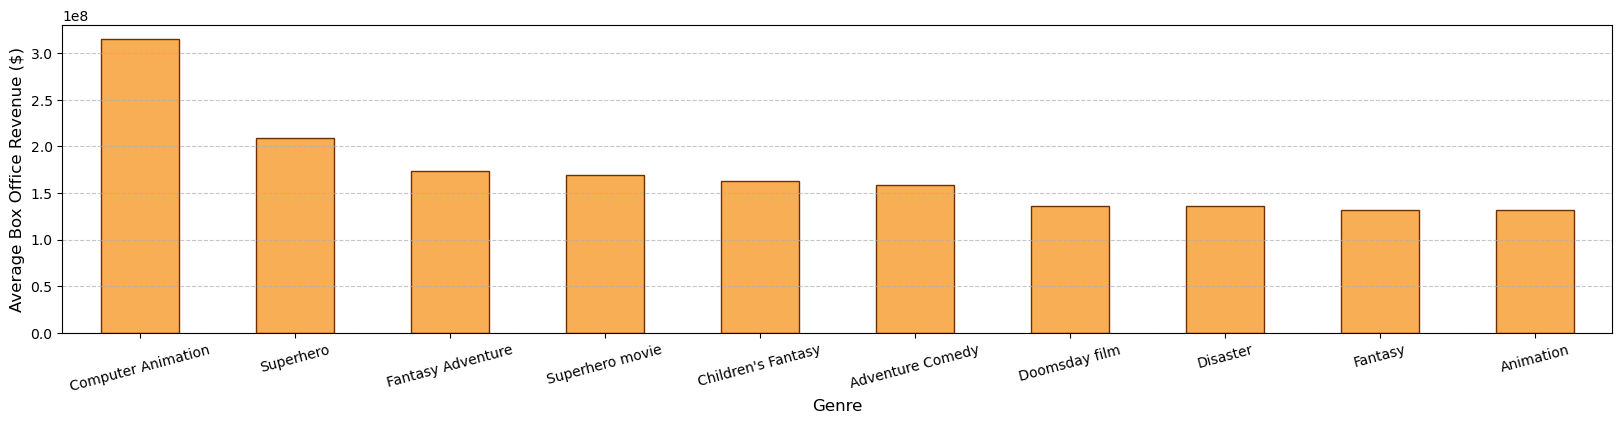

In [30]:
movies_with_genres = movies.explode('Extracted Genres')

genre_revenue = movies_with_genres.groupby('Extracted Genres')['Movie box office revenue'].mean().sort_values(ascending=False)

LIMIT_SAMPLE = 50
genre_counts = movies_with_genres['Extracted Genres'].value_counts()
valid_genres = genre_counts[genre_counts >= LIMIT_SAMPLE].index  

movies_with_valid_genres = movies_with_genres[movies_with_genres['Extracted Genres'].isin(valid_genres)]

genre_revenue = movies_with_valid_genres.groupby('Extracted Genres')['Movie box office revenue'].mean().sort_values(ascending=False)

plt.figure(figsize=(20, 4))
genre_revenue.head(10).plot(kind='bar', alpha=1, color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR)
# plt.title(f'Top 10 Genres by Average Box Office Revenue (Genres with > {LIMIT_SAMPLE+1} Movies)', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Box Office Revenue ($)', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

This graph varies heavily on sample size.

#### Histogram using TMDB

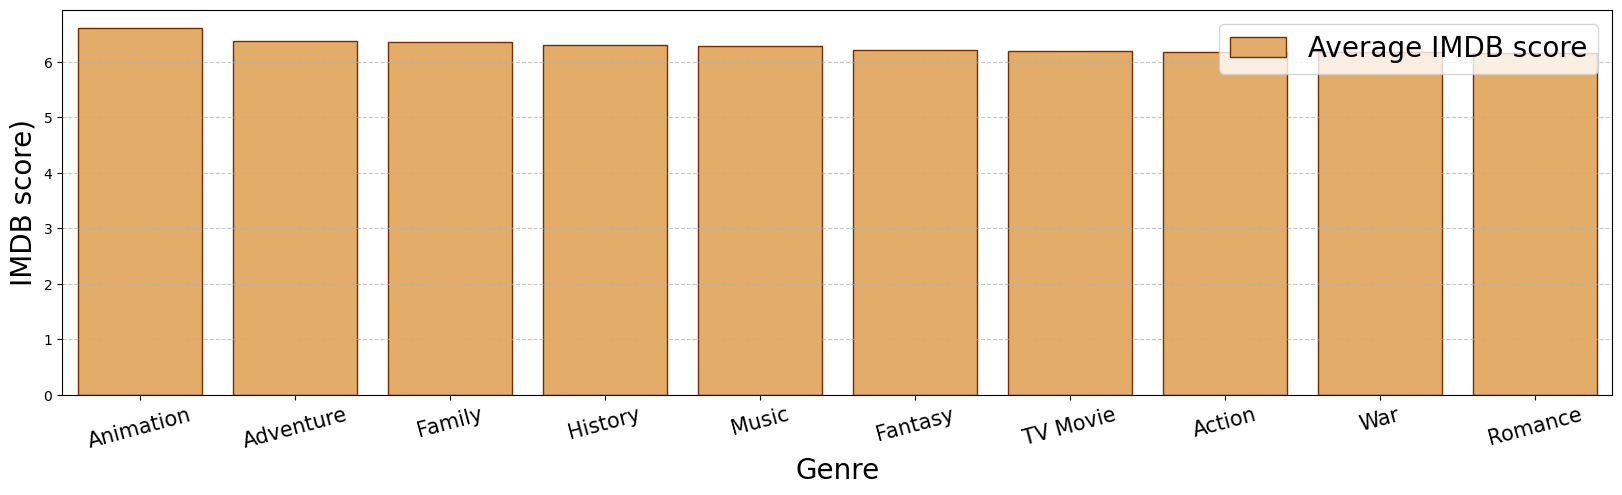

In [31]:
# Columns to show
columns = ['net revenue', 'budget']
c = 'vote_average'

# Drop rows with no genres, zero budget, or zero revenue
tmdb_cleaned = tmdb.dropna(subset=['Extracted Genres', 'vote_average'])

# Explode genres into separate rows
tmdb_exploded = tmdb_cleaned.explode('Extracted Genres')

# Group by genre and calculate average budget and net revenue
genre_stats = tmdb_exploded.groupby('Extracted Genres')[['vote_average']].mean().sort_values(by=c, ascending=False)

# Plot the top 10 genres with a stacked bar chart
top_genres = genre_stats.head(10)

# Adjust the stacked bar
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=top_genres.index, y=top_genres['vote_average'], color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR, label='Average IMDB score')
# Customize the plot
# plt.title('Top 10 Genres by Average Revenue and Budget', fontsize=26)
plt.xlabel('Genre', fontsize=20)
plt.ylabel('IMDB score)', fontsize=20)
plt.xticks(fontsize=15, rotation=15)
plt.legend(fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [32]:
genre_stats

,vote_average
Extracted Genres,
Animation,6.613410
Adventure,6.374386
Family,6.360382
History,6.303905
Music,6.288018
Fantasy,6.221348
TV Movie,6.197369
Action,6.185272
War,6.183455


The data from the TMDB is a lot more representative when it comes to genre vs box office. 
We can see that adventure is at the top with 746 movies and the top 5 are:
- Avatar
- Avangers: End Game
- Avatar: The Way of Water
- Star Wars: The Force Awakens
- Avengers: Infinity War

# Genre Combination

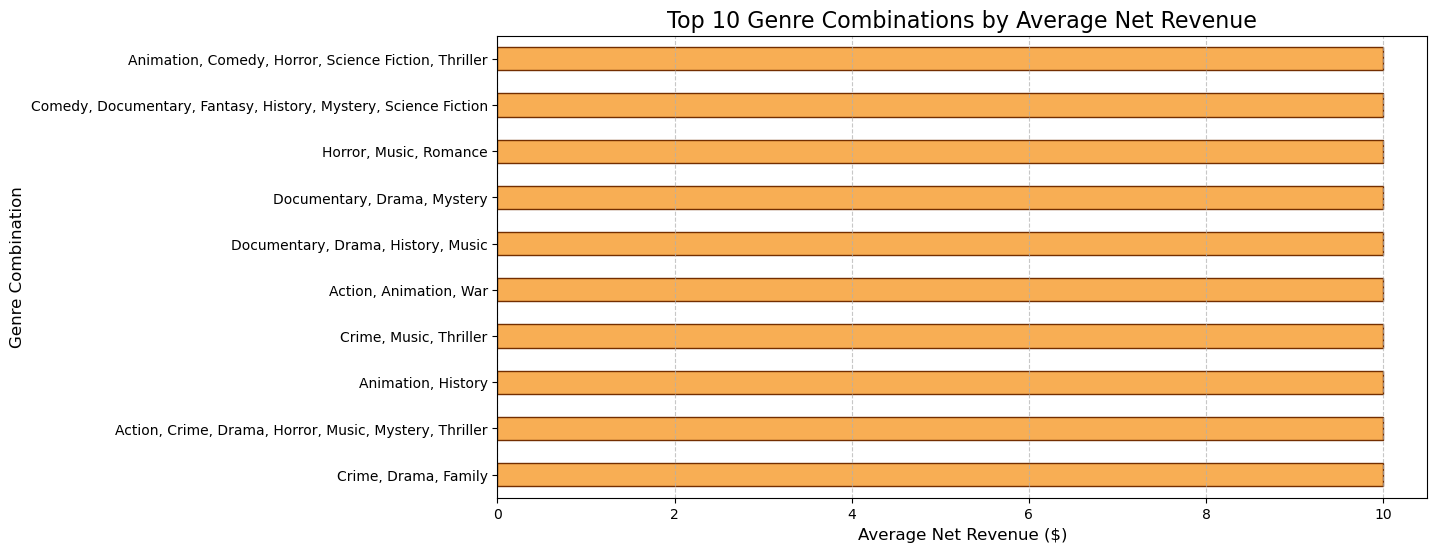

In [33]:
# Count most common genre combinations
tmdb['Genre Combination'] = tmdb['Extracted Genres'].apply(lambda x: ', '.join(sorted(x)))
combination_stats = tmdb.groupby('Genre Combination')['vote_average'].mean().sort_values(ascending=False)

# Plot top 10 genre combinations by average revenue
top_combinations = combination_stats.head(10)
plt.figure(figsize=(12, 6))
top_combinations.plot(kind='barh', color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR)
plt.title('Top 10 Genre Combinations by Average Net Revenue', fontsize=16)
plt.xlabel('Average Net Revenue ($)', fontsize=12)
plt.ylabel('Genre Combination', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# Number  of Genres

#### Histogram of number of genres and mean revenue

In [38]:
# Count most common genre combinations
tmdb_cleaned['Genre Combination'] = tmdb_cleaned['Extracted Genres'].apply(lambda x: ', '.join(sorted(x)))
combination_stats = tmdb_cleaned.groupby('Genre Combination')[['vote_average']].mean().sort_values(by='vote_average', ascending=False)

# Display top combinations
combination_stats.head(10)

,vote_average
Genre Combination,
"Crime, Drama, Family",10.0
"Action, Crime, Drama, Horror, Music, Mystery, Thriller",10.0
"Animation, History",10.0
"Crime, Music, Thriller",10.0
"Action, Animation, War",10.0
"Documentary, Drama, History, Music",10.0
"Documentary, Drama, Mystery",10.0
"Horror, Music, Romance",10.0
"Comedy, Documentary, Fantasy, History, Mystery, Science Fiction",10.0


# Histogram of number of frequency

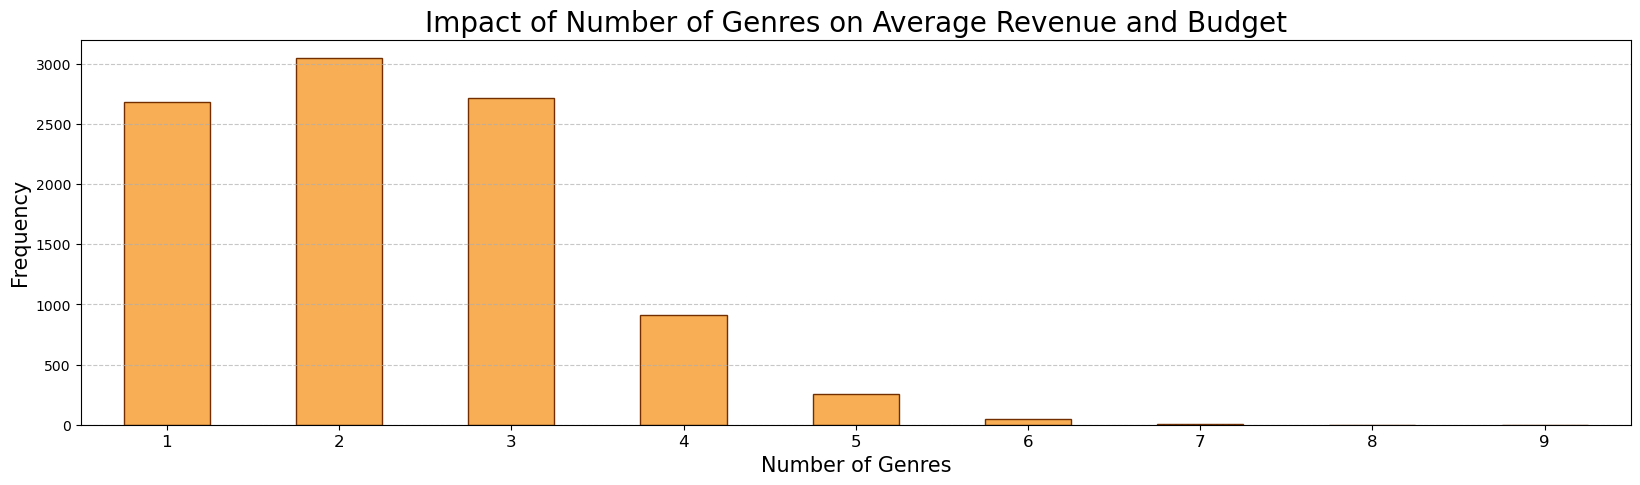

In [42]:
# Calculate the number of genres for each movie
tmdb_cleaned['Number of Genres'] = tmdb_cleaned['Extracted Genres'].apply(len)

# Group by the number of genres and calculate the average net revenue and budget
genre_count_count = tmdb_cleaned.groupby('Number of Genres')[['vote_average']].count()

# Plot the average metrics by number of genres
fig, ax = plt.subplots(figsize=(20, 5))
genre_count_count['vote_average'].plot(kind='bar', color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR, ax=ax, label=get_capitalized_first_letter('vote_average'), alpha=1)
# genre_count_count[columns[0]].plot(kind='bar', color=GRAPH_COLOR?S[0], edgecolor=GRAPH_EDGECOLOR, ax=ax, bottom=genre_count_count[columns[1]], label=get_capitalized_first_letter(columns[0]), alpha=1)

# Customize the plot
plt.title('Impact of Number of Genres on Average Revenue and Budget', fontsize=20)
plt.xlabel('Number of Genres', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=12, rotation=0)
# plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
